In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EDA

In [ ]:
# Descomprimir .zip
!unzip "/content/drive/MyDrive/PROYECTOS/Manatee_Project/manatee_data.zip" -d "/content/manatee_data/"

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: /content/manatee_data/Manatee_fulltraining_final/Noise/20220324T205316_3633316363674125_8.1_257.6.wav  
  inflating: /content/manatee_data/Manatee_fulltraining_final/Noise/20220324T205316_3633316363674125_8.1_258.4.wav  
  inflating: /content/manatee_data/Manatee_fulltraining_final/Noise/20220324T205316_3633316363674125_8.1_258.8.wav  
  inflating: /content/manatee_data/Manatee_fulltraining_final/Noise/20220324T205316_3633316363674125_8.1_26.wav  
  inflating: /content/manatee_data/Manatee_fulltraining_final/Noise/20220324T205316_3633316363674125_8.1_260.8.wav  
  inflating: /content/manatee_data/Manatee_fulltraining_final/Noise/20220324T205316_3633316363674125_8.1_265.2.wav  
  inflating: /content/manatee_data/Manatee_fulltraining_final/Noise/20220324T205316_3633316363674125_8.1_265.6.wav  
  inflating: /content/manatee_data/Manatee_fulltraining_final/Noise/20220324T205316_3633316363674125_8.1_275.6.wav  


In [ ]:
import os

# Modificamos rutas si es necesario
path_mv = '/content/manatee_data/Manatee_fulltraining_final/MV/'
path_noise = '/content/manatee_data/Manatee_fulltraining_final/Noise/'

num_mv_clips = len(os.listdir(path_mv))
num_noise_clips = len(os.listdir(path_noise))

print(f"Clips de Manatíes (MV): {num_mv_clips}")
print(f"Clips de Ruido (Noise): {num_noise_clips}")

Clips de Manatíes (MV): 18128
Clips de Ruido (Noise): 23443


In [ ]:
import IPython.display as ipd

# Archivo de audio al azar para escucharlo
sample_clip_path = os.path.join(path_mv, os.listdir(path_mv)[39])
print("Reproduciendo un clip de manatí:")
ipd.Audio(sample_clip_path)

Reproduciendo un clip de manatí:


In [ ]:
import librosa

# Carga el archivo de audio
y, sr = librosa.load(sample_clip_path)

print(f"Tasa de muestreo (Sample Rate): {sr} Hz")
print(f"Duración del clip: {len(y)/sr:.2f} segundos")

Tasa de muestreo (Sample Rate): 22050 Hz
Duración del clip: 0.50 segundos


# PREPROCESSING

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import os

# Rutas a las carpetas
path_mv = '/content/manatee_data/Manatee_fulltraining_final/MV/'
path_noise = '/content/manatee_data/Manatee_fulltraining_final/Noise/'

# Crear una lista de todas las rutas de archivo y sus etiquetas
# Etiqueta 1 para Manatí (MV), Etiqueta 0 para Ruido (Noise)
filepaths = [os.path.join(path_mv, f) for f in os.listdir(path_mv)] + \
            [os.path.join(path_noise, f) for f in os.listdir(path_noise)]

labels = [1] * len(os.listdir(path_mv)) + [0] * len(os.listdir(path_noise))

# División 80/20 para entrenamiento y el resto
train_filepaths, test_val_filepaths, train_labels, test_val_labels = train_test_split(
    filepaths,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels  # Para mantener el balance de clases
)

# El 20% restante en 10% para validación y 10% para prueba
val_filepaths, test_filepaths, val_labels, test_labels = train_test_split(
    test_val_filepaths,
    test_val_labels,
    test_size=0.5,
    random_state=42,
    stratify=test_val_labels
)

print(f"Archivos de entrenamiento: {len(train_filepaths)}")
print(f"Archivos de validación: {len(val_filepaths)}")
print(f"Archivos de prueba: {len(test_filepaths)}")

Archivos de entrenamiento: 33256
Archivos de validación: 4157
Archivos de prueba: 4158


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm # Para tener una barra de progreso

# La tasa de muestreo debe ser consistente (salio 22050 en las pruebas)
SAMPLE_RATE = 22050

def create_mel_spectrogram(filepath):
    """Carga un archivo de audio y lo convierte en un mel-espectrograma"""
    try:
        y, sr = librosa.load(filepath, sr=SAMPLE_RATE)
        # Todos los clips con misma longitud
        y = librosa.util.fix_length(y, size=sr // 2) # // 2 porque los clips son de 0.5s

        # Generar mel-espectrograma
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

        # Convertir a decibelios (dB) para una mejor representación
        log_S = librosa.power_to_db(S, ref=np.max)
        return log_S
    except Exception as e:
        print(f"Error procesando {filepath}: {e}")
        return None

# Procesar todos los datos
print("Procesando datos de entrenamiento")
X_train = np.array([create_mel_spectrogram(fp) for fp in tqdm(train_filepaths)])
y_train = np.array(train_labels)

print("Procesando datos de validación")
X_val = np.array([create_mel_spectrogram(fp) for fp in tqdm(val_filepaths)])
y_val = np.array(val_labels)

print("Procesando datos de prueba")
X_test = np.array([create_mel_spectrogram(fp) for fp in tqdm(test_filepaths)])
y_test = np.array(test_labels)

print("\nProcesamiento listo")
print(f"Forma de X_train: {X_train.shape}")

Procesando datos de entrenamiento


100%|██████████| 33256/33256 [04:05<00:00, 135.28it/s]


Procesando datos de validación


100%|██████████| 4157/4157 [00:32<00:00, 127.96it/s]


Procesando datos de prueba


100%|██████████| 4158/4158 [00:30<00:00, 137.79it/s]


Procesamiento listo
Forma de X_train: (33256, 128, 22)


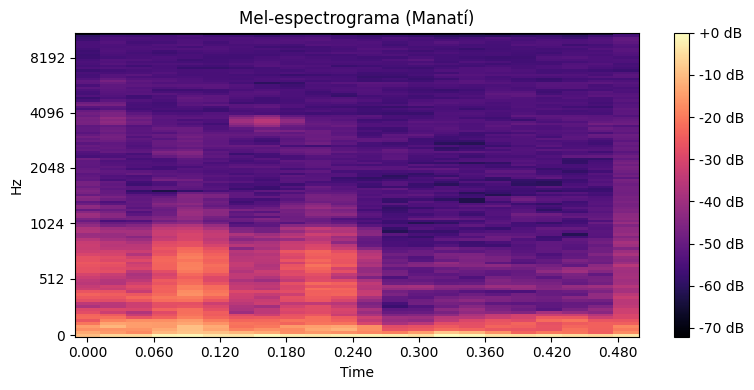

In [ ]:
# Espectrograma
plt.figure(figsize=(8, 4))
librosa.display.specshow(X_train[1], sr=SAMPLE_RATE, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-espectrograma (Manatí)')
plt.tight_layout()
plt.show()

# CNN

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Añadir un canal y convertir a tensores de PyTorch, de "(num_samples, altura, ancho)" a "(num_samples, canales, altura, ancho)"
X_train_tensor = torch.from_numpy(X_train).unsqueeze(1).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)

X_val_tensor = torch.from_numpy(X_val).unsqueeze(1).float()
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)

X_test_tensor = torch.from_numpy(X_test).unsqueeze(1).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

# Repetir el canal para que sean 3 canales
X_train_tensor = X_train_tensor.repeat(1, 3, 1, 1)
X_val_tensor = X_val_tensor.repeat(1, 3, 1, 1)
X_test_tensor = X_test_tensor.repeat(1, 3, 1, 1)

# Crear datasets y dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

BATCH_SIZE = 64 # Se puede cambiar

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Forma de un lote de datos: {next(iter(train_loader))[0].shape}")

Forma de un lote de datos: torch.Size([64, 3, 128, 22])


In [ ]:
import torchvision.models as models

# Cargar un ResNet18 pre-entrenado
model = models.resnet18(weights='IMAGENET1K_V1')

# Primero congelamos todo
for param in model.parameters():
    param.requires_grad = False

# Descongelamos los parámetros del último bloque convolucional (layer4) y la capa final
for param in model.layer4.parameters():
    param.requires_grad = True

# Reemplazar la última capa (el clasificador), que se entrenará por defecto
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

# Mover el modelo a la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


In [ ]:
import torchaudio.transforms as T

# Definimos un pipeline de aumento de datos
augmentation_pipeline = torch.nn.Sequential(
    T.FrequencyMasking(freq_mask_param=4), # Tapa bandas de frecuencia de Mel
    T.TimeMasking(time_mask_param=8)      # Tapa pasos de tiempo (frames)
).to(device)

In [ ]:
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Función de pérdida y optimizador, BCEWithLogitsLoss para clasificación binaria
criterion = nn.BCEWithLogitsLoss()
# Optimizador con tasas de aprendizaje diferenciales
optimizer = torch.optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 1e-5}, # Tasa de aprendizaje muy baja para las capas descongeladas
    {'params': model.fc.parameters(), 'lr': 1e-4}      # Tasa de aprendizaje un poco más alta para la nueva capa
])

# Añadir un planificador
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# Bucle de entrenamiento
NUM_EPOCHS = 15

# Variable para la mejor precisión antes del bucle
best_val_accuracy = 0.0
model_path = "best_manatee_model_B.pth"

for epoch in range(NUM_EPOCHS):
    # Entrenamiento
    model.train() # Poner el modelo en modo de entrenamiento
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]"):
        inputs, labels = inputs.to(device), labels.to(device)

        # AUMENTO DE DATOS AQUÍ (solo durante el entrenamiento)
        inputs = augmentation_pipeline(inputs)

        # Poner los gradientes a cero
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass y optimización
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # Validación
    model.eval() # Poner el modelo en modo de evaluación
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad(): # No necesitamos calcular gradientes en validación
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calcular la precisión
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_loss = val_loss / len(val_loader.dataset)
    accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {validation_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

    # Guardar mejor modelo
    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        torch.save(model.state_dict(), model_path)
        print(f"Nuevo mejor modelo guardado con {accuracy:.2f}% de precisión")

    # Actualizar el planificador
    scheduler.step(validation_loss)

Epoch 1/15 [Validation]: 100%|██████████| 65/65 [00:00<00:00, 116.99it/s]


Epoch 1: Train Loss: 0.4992, Val Loss: 1.0864, Val Accuracy: 67.81%
Nuevo mejor modelo guardado con 67.81% de precisión


Epoch 2/15 [Validation]: 100%|██████████| 65/65 [00:00<00:00, 117.76it/s]


Epoch 2: Train Loss: 0.4112, Val Loss: 0.9065, Val Accuracy: 66.85%


Epoch 3/15 [Validation]: 100%|██████████| 65/65 [00:00<00:00, 114.39it/s]


Epoch 3: Train Loss: 0.3801, Val Loss: 0.7620, Val Accuracy: 69.76%
Nuevo mejor modelo guardado con 69.76% de precisión


Epoch 4/15 [Validation]: 100%|██████████| 65/65 [00:00<00:00, 119.69it/s]


Epoch 4: Train Loss: 0.3601, Val Loss: 0.6966, Val Accuracy: 70.72%
Nuevo mejor modelo guardado con 70.72% de precisión


Epoch 5/15 [Validation]: 100%|██████████| 65/65 [00:00<00:00, 120.16it/s]


Epoch 5: Train Loss: 0.3504, Val Loss: 0.5946, Val Accuracy: 74.74%
Nuevo mejor modelo guardado con 74.74% de precisión


Epoch 6/15 [Validation]: 100%|██████████| 65/65 [00:00<00:00, 115.03it/s]


Epoch 6: Train Loss: 0.3406, Val Loss: 0.6421, Val Accuracy: 73.59%


Epoch 7/15 [Validation]: 100%|██████████| 65/65 [00:00<00:00, 120.67it/s]


Epoch 7: Train Loss: 0.3269, Val Loss: 0.7354, Val Accuracy: 71.47%


Epoch 8/15 [Validation]: 100%|██████████| 65/65 [00:00<00:00, 119.37it/s]


Epoch 8: Train Loss: 0.3336, Val Loss: 0.6751, Val Accuracy: 72.22%


Epoch 9/15 [Validation]: 100%|██████████| 65/65 [00:00<00:00, 118.98it/s]


Epoch 9: Train Loss: 0.3263, Val Loss: 0.8576, Val Accuracy: 68.13%


Epoch 10/15 [Validation]: 100%|██████████| 65/65 [00:00<00:00, 119.02it/s]


Epoch 10: Train Loss: 0.3161, Val Loss: 0.7345, Val Accuracy: 71.28%


Epoch 11/15 [Validation]: 100%|██████████| 65/65 [00:00<00:00, 119.10it/s]


Epoch 11: Train Loss: 0.3206, Val Loss: 0.7599, Val Accuracy: 69.86%


Epoch 12/15 [Validation]: 100%|██████████| 65/65 [00:00<00:00, 119.60it/s]


Epoch 12: Train Loss: 0.3283, Val Loss: 0.8085, Val Accuracy: 68.10%


Epoch 13/15 [Validation]: 100%|██████████| 65/65 [00:00<00:00, 113.34it/s]


Epoch 13: Train Loss: 0.3199, Val Loss: 0.8289, Val Accuracy: 67.93%


Epoch 14/15 [Validation]: 100%|██████████| 65/65 [00:00<00:00, 118.95it/s]


Epoch 14: Train Loss: 0.3229, Val Loss: 0.8292, Val Accuracy: 68.94%


Epoch 15/15 [Validation]: 100%|██████████| 65/65 [00:00<00:00, 119.13it/s]

Epoch 15: Train Loss: 0.3191, Val Loss: 0.8541, Val Accuracy: 67.38%


Evaluación del Modelo A (Sin aumento)
              precision    recall  f1-score   support

       Noise       0.92      0.95      0.93      2345
     Manatee       0.93      0.89      0.91      1813

    accuracy                           0.92      4158
   macro avg       0.92      0.92      0.92      4158
weighted avg       0.92      0.92      0.92      4158



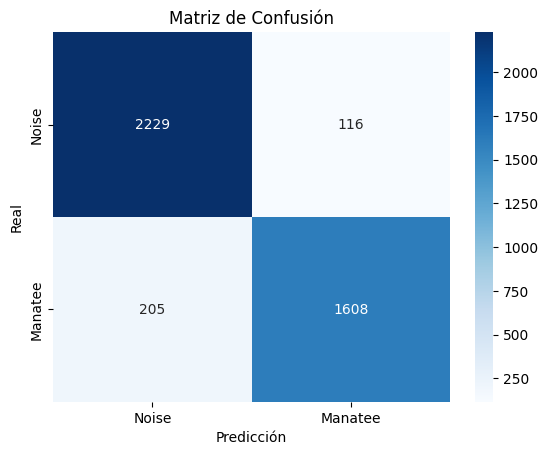

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Recrea la arquitectura del modelo
model_specialist = models.resnet18() # Recrea la arquitectura
num_ftrs = model_specialist.fc.in_features
model_specialist.fc = nn.Linear(num_ftrs, 1)

# 2. Carga los pesos guardados
model_specialist.load_state_dict(torch.load("/content/best_manatee_model_A.pth")) # Cargar los pesos guardados
# Mueve el modelo a la GPU si es necesario
model_specialist.to(device)

print("Evaluación del Modelo A (Sin aumento)")

# 3. Modelo en modo de evaluación
model_specialist.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_specialist(inputs)
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Reporte de Clasificación
print(classification_report(all_labels, all_preds, target_names=['Noise', 'Manatee']))

# Matriz de Confusión
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Noise', 'Manatee'], yticklabels=['Noise', 'Manatee'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Evaluación del Modelo B (Con aumento)
              precision    recall  f1-score   support

       Noise       0.69      0.99      0.81      2345
     Manatee       0.98      0.41      0.58      1813

    accuracy                           0.74      4158
   macro avg       0.83      0.70      0.70      4158
weighted avg       0.81      0.74      0.71      4158



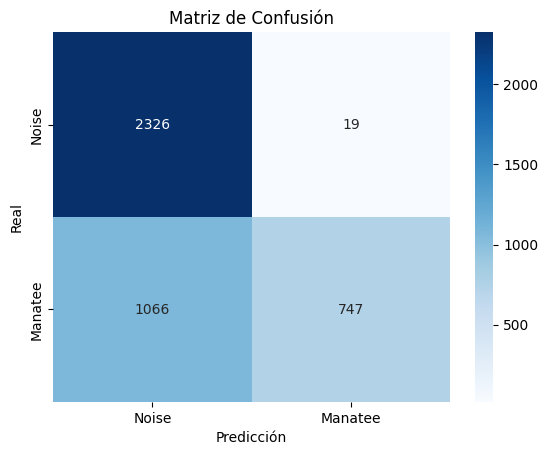

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Recrea la arquitectura del modelo
model_generalist = models.resnet18() # Recrea la arquitectura
num_ftrs = model_generalist.fc.in_features
model_generalist.fc = nn.Linear(num_ftrs, 1)

# 2. Carga los pesos guardados
model_generalist.load_state_dict(torch.load("/content/best_manatee_model_B.pth")) # Cargar los pesos guardados
# Mueve el modelo a la GPU si es necesario
model_generalist.to(device)

print("Evaluación del Modelo B (Con aumento)")

# 3. Modelo en modo de evaluación
model_generalist.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_generalist(inputs)
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Reporte de Clasificación
print(classification_report(all_labels, all_preds, target_names=['Noise', 'Manatee']))

# Matriz de Confusión
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Noise', 'Manatee'], yticklabels=['Noise', 'Manatee'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# NEW DATA

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models

# Cargar el modelo
# Define la arquitectura del modelo (igual al entrenamiento)
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

# Carga los pesos
model_path = "/content/drive/MyDrive/PROYECTOS/Manatee_Project/best_manatee_model_A.pth"
model.load_state_dict(torch.load(model_path))

# Modelo en modo de evaluación
model.eval()

# Mueve el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Modelo cargado")

Modelo cargado y listo para usar.


In [2]:
import librosa
import numpy as np

# Función de preprocesamiento
def preprocess_audio(file_path, sample_rate=22050):
    """
    Toma la ruta de un archivo de audio y lo convierte en un tensor
    listo para el modelo
    """
    try:
        # 1. Cargar el audio
        y, sr = librosa.load(file_path, sr=sample_rate)

        # 2. Longitud del audio (0.5 segundos), si el audio es más largo, toma el centro; si es más corto, lo rellena.
        center_point = len(y) // 2
        half_duration = sr // 4 # 0.25 segundos a cada lado
        start_sample = max(0, center_point - half_duration)
        end_sample = min(len(y), center_point + half_duration)
        y_clipped = y[start_sample:end_sample]
        y_fixed = librosa.util.fix_length(y_clipped, size=sr // 2)

        # 3. Crea mel-espectrograma (igual que en el entrenamiento)
        S = librosa.feature.melspectrogram(y=y_fixed, sr=sr, n_mels=128)
        log_S = librosa.power_to_db(S, ref=np.max)

        # 4. Convertir a tensor de PyTorch
        tensor = torch.from_numpy(log_S).float()
        tensor = tensor.unsqueeze(0)  # Añadir dimensión de canal: (1, altura, ancho)
        tensor = tensor.repeat(3, 1, 1) # Repetir para 3 canales: (3, altura, ancho)
        tensor = tensor.unsqueeze(0)  # Añadir dimensión de lote: (1, 3, altura, ancho)

        return tensor

    except Exception as e:
        print(f"Error procesando el archivo {file_path}: {e}")
        return None

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models

# 1. Cargar el modelo entrenado
# Esta arquitectura es la misma que para entrenar
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

# Ruta al archivo .pth
model_path = "/content/drive/MyDrive/PROYECTOS/Manatee_Project/best_manatee_model_A.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carga los pesos guardados
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

# Poner el modelo en modo de evaluación
model.eval()
print(f"Modelo '{model_path}' cargado en dispositivo '{device}'.")


# 2. Especificar el archivo de audio y preprocesarlo
new_audio = "/content/drive/MyDrive/PROYECTOS/Manatee_Project/TEST_MV/MV3.wav"
input_tensor = preprocess_audio(new_audio)


# 3. Realizar la predicción
if input_tensor is not None:
    # Mueve el tensor al mismo dispositivo que el modelo
    input_tensor = input_tensor.to(device)

    # Realiza la predicción (desactivando el cálculo de gradientes)
    with torch.no_grad():
        output = model(input_tensor)

    # 4. Interpretar y mostrar el resultado
    # Aplica la función sigmoide para obtener una probabilidad
    probability = torch.sigmoid(output).item()

    # Decide la clase usando un umbral de 0.5
    prediction = "Manatí" if probability > 0.5 else "Ruido"

    print(f"\nResultado para: {new_audio}")
    print(f"   Predicción: {prediction}")
    print(f"   Confianza (de ser manatí): {probability * 100:.2f}%")
    print("------------------------------------")

Modelo '/content/drive/MyDrive/PROYECTOS/Manatee_Project/best_manatee_model_A.pth' cargado en dispositivo 'cuda'.

Resultado para: /content/drive/MyDrive/PROYECTOS/Manatee_Project/TEST_MV/MV3.wav
   Predicción: Manatí
   Confianza (de ser manatí): 96.00%
------------------------------------


# DETECTION SCRIPT (Work in process)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip

# 1. CONFIGURACIÓN
VIDEO_PATH = "ruta/a/video.mp4"
AUDIO_PATH = "audio_extraido.wav"
MODEL_PATH = "best_manatee_model_A.pth"
DEVICE = torch.device("cpu")

# Parámetros de la ventana deslizante
WINDOW_DURATION_S = 0.5  # Debe coincidir con la duración de entrenamiento
STEP_DURATION_S = 0.1    # Cuánto se desliza la ventana cada vez (menor = más preciso pero más lento)
CONFIDENCE_THRESHOLD = 0.90 # Umbral para considerar una detección como positiva (ajusta según el modelo)

#2. CARGAR MODELO Y EXTRAER AUDIO
# Cargar el modelo
print("Cargando modelo")
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()
print("Modelo cargado")

# Extraer el audio del video
print(f"Extrayendo audio de {VIDEO_PATH}")
video_clip = VideoFileClip(VIDEO_PATH)
video_clip.audio.write_audiofile(AUDIO_PATH, codec='pcm_s16le')
print(f"Audio guardado en {AUDIO_PATH}")

# 3. ANÁLISIS CON VENTANA DESLIZANTE
# Cargar el audio extraído
y, sr = librosa.load(AUDIO_PATH, sr=22050)
duration_s = len(y) / sr

# Función de preprocesamiento de chunks
def preprocess_chunk(audio_chunk, sample_rate):
    chunk_samples = int(WINDOW_DURATION_S * sample_rate)
    audio_chunk = librosa.util.fix_length(data=audio_chunk, size=chunk_samples)
    S = librosa.feature.melspectrogram(y=audio_chunk, sr=sample_rate, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)
    tensor = torch.from_numpy(log_S).float().to(DEVICE)
    tensor = tensor.unsqueeze(0).repeat(3, 1, 1).unsqueeze(0)
    return tensor

detections = []
print("Analizando audio")

# El bucle de la ventana deslizante
window_samples = int(WINDOW_DURATION_S * sr)
step_samples = int(STEP_DURATION_S * sr)

for i in range(0, len(y) - window_samples, step_samples):
    # Extraer el chunk actual
    chunk = y[i : i + window_samples]

    # Preprocesar y predecir
    input_tensor = preprocess_chunk(chunk, sr)
    with torch.no_grad():
        output = model(input_tensor)

    probability = torch.sigmoid(output).item()

    # Si la confianza es alta, guardar la marca de tiempo
    if probability > CONFIDENCE_THRESHOLD:
        start_time = i / sr
        end_time = (i + window_samples) / sr
        detections.append((start_time, end_time, probability))

print(f"Análisis completo. Se encontraron {len(detections)} detecciones")

# 4. VISUALIZAR LOS RESULTADOS
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y, sr=sr, alpha=0.6)
plt.title('Detecciones de Sonido de Manatí')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')

# Dibujar un recuadro por cada detección
for start, end, prob in detections:
    plt.axvspan(start, end, color='red', alpha=0.4)
    plt.text(start, plt.ylim()[1] * 0.9, f'{prob*100:.0f}%', color='black')

plt.tight_layout()
plt.show()